# Load Packages
- We use `torch`package.
- We use `pytorch_lightning` packages to simplify fitting and evaluate models.

In [4]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.linear_model import \
     (LinearRegression, LogisticRegression, Lasso)
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from ISLP import load_data
from ISLP.models import ModelSpec as MS

### Torch-Specific Imports
There are a number of imports for `torch`. (These are not
included with `ISLP`, so must be installed separately.)
First we import the main library
and essential tools used to specify sequentially-structured networks.

- Main library and essential tools to specify sequentially-structured networks

In [5]:
import torch
from torch import nn
from torch.optim import RMSprop
from torch.utils.data import TensorDataset

- Tools from `torchmetrics` to compute metrics to evaluate performance.
- Tools from `torchinfo` to summarize info of the layers of a model.

In [6]:
from torchmetrics import (MeanAbsoluteError, R2Score)
from torchinfo import summary

- `pytorch_lightning` package simplifies the specification and fitting and evaluate models by reducing amount of boilerplate code needed.
- `pytorch_lightning` is higher-level interface than `torch`.
- `pytorch_lightning` is a high-level module for fitting `torch` models

In [7]:
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import CSVLogger

- `seed_everything()` set seed.
- `use_deterministic_algorithms` fix algorithms.

In [8]:
from pytorch_lightning import seed_everything
seed_everything(0, workers=True)
torch.use_deterministic_algorithms(True, warn_only=True)

Seed set to 0


- We use datasets from `torchvision`.
- We use transforms from `torchvision` for preprocessing.
- We use a pretrained network for image classification

In [9]:
from torchvision.io import read_image
from torchvision.datasets import MNIST, CIFAR100
from torchvision.models import (resnet50, ResNet50_Weights)
from torchvision.transforms import (Resize, Normalize,
                                    CenterCrop, ToTensor)

- `SimpleDataModule` and `SimpleModule` from `ISLP.torch` are simple versions of objects used in `pytorch_lightning`.
- `ErrorTracker` collects targets and predictions over each mini-batch during validation or testing, enabling metric computation over the entire validation or test data set.
- `read_image()` load test images

In [10]:
from ISLP.torch import (SimpleDataModule, SimpleModule,
                        ErrorTracker, rec_num_workers)

- We use helper functions from `ISLP.torch.imdb` to load data, lookup that maps integers to keys in data.
- We use a modified copy of the preprocessed `imdb` data from `keras`. It saves time for preprocessing.
    - `keras` is a separate package for fitting deep learning models.

In [10]:
from ISLP.torch.imdb import (load_lookup, load_tensor,
                             load_sparse, load_sequential)

- We use `glob()` from `glob` package to find all files matching wildcard characters.
- We use `json` module to load JSON file for looking up classes to identify labels of the pictures in `ResNet50`.

In [11]:
from glob import glob; import json

# Single Layer Network on Hitters Data
- Major League Baseball Data from the 1986 and 1987 seasons.
- There are 322 rows, with 59 rows of missing values. 263 left.
- There are 20 variables.
- The response is `Salary`.

In [12]:
Hitters = load_data('Hitters').dropna()
# Number of observations
n = Hitters.shape[0]

- We fit two linear models (least squares  and lasso) and  compare their performance to that of a neural network.
- We use mean absolute error (MAE) on a validation dataset to compare the models.
    $$ {MAE}(y,\hat{y}) = \frac{1}{n} \sum_{i=1}^n |y_i-\hat{y}_i|.$$

In [13]:
# Design matrix without intercept
Design_matrix = MS(Hitters.columns.drop('Salary'), intercept=False)
# Convert to numpy arrays
X = Design_matrix.fit_transform(Hitters).to_numpy()
Y = Hitters['Salary'].to_numpy()

- `to_numpy()` converts `pandas` data frames or series to `numpy` arrays because `sklearn` requires `numpy` arrays to fit lasso.

In [14]:
# Split the data into training and test sets
X_train,X_test,Y_train,Y_test = train_test_split(
    X, Y, test_size=1/3, random_state=1)

## Linear Regression

In [15]:
hit_lm = LinearRegression().fit(X_train, Y_train)
Yhat_test = hit_lm.predict(X_test)
# Mean absolute error (MAE)
print('MAE of Linear:', np.abs(Yhat_test - Y_test).mean())

MAE of Linear: 259.71528833146294


## Lasso Regression

- We use MAE to select and evaluate a model, rather than MSE.
- Because the solver uses only MSE, we need to create a cross-validation grid and perform the cross-validation directly.
- We do a pipeline: normalize using `StandardScaler`, then fit the model.

In [16]:
scaler = StandardScaler(with_mean=True, with_std=True)
lasso = Lasso(warm_start=True, max_iter=30000)
standard_lasso = Pipeline(steps=[('scaler', scaler),
                                 ('lasso', lasso)])

- `warm_start=True`: The model will reuse the solution of the previous fit as the starting point for the next fit. This can speed up convergence when fitting the model multiple times.
- `max_iter=10000`: The maximum number of iterations.
- We identify the maximum value of $\lambda$ (`lam_max`):
    - We compute the dot product of the standardized predictors with the response to capture their relationship.
    - We take the maximum abolute value of the dot product to identify the feature with the strongest relationship with the response.
    - We devide this value by the number of observations to normalize it.
- We create a grid of values for $\lambda$.
    - We choose a grid of 100 values of $\lambda$ from 0.01 to 1
    - We scale the grid by `lam_max`

In [17]:
# Standardize the predictors
X_s = scaler.fit_transform(X_train)
# Number of observations
n = X_s.shape[0]
# Calculate the Mean-Centered Response Vector
Y_centered = Y_train - Y_train.mean()
# Calculate the Dot Product
dot_product = X_s.T.dot(Y_centered)
# Calculate the maximum absolute value of the dot product
max_abs_value = np.fabs(dot_product).max()
# np.fabs() is a special function handling floating points. np.abs() is a general function.
# Compute lam_max
lam_max = max_abs_value / n # 255.658
# Generate a range of values
log_alpha_values = np.linspace(0, np.log(0.01), 100) # 0 to -4.605
# Exponentiate the values
alpha_values = np.exp(log_alpha_values) # 1 to 0.01
# Scale by lam_max
scaled_alpha_values = alpha_values * lam_max
# Create a param_grid
param_grid = {'lasso__alpha': scaled_alpha_values}

In [18]:
# Set up a 10-fold cross-validation
cv10 = KFold(10, shuffle=True, random_state=1)
grid = GridSearchCV(standard_lasso, param_grid, cv=cv10,
                    scoring='neg_mean_absolute_error')
grid.fit(X_train, Y_train);

In [19]:
# Extract the best estimator
trained_lasso = grid.best_estimator_
# Predict the test set
Yhat_test = trained_lasso.predict(X_test)
# Show MAE
print('MAE of Lasso:', np.abs(Yhat_test - Y_test).mean())

MAE of Lasso: 235.6754837478029


## Neural Network: Classes and Inheritance
- We first set up a model structure that describes the network.
- We define new classes specific to the model we wish to fit.
- `pytorch` do this task by sub-classing a generic representation of a network.
- We define a class `HittersModel` that inherits from `torch.nn.Module`. This base class is the parent class for all neural network modules in `pytorch`.
- We define the `__init__()` method to specify the structure of the network.
    - `super(HittersModel, self).__init__()`: Calls the constructor of the parent class nn.Module to initialize the base class.
    - We attact two attributes to the class: `flatten` and `sequential`. They are used in the `forward()` method to describe the map that this module implements.
    - `self.flatten = nn.Flatten()`: Defines a layer that flattens the input tensor. This is useful if the input is multi-dimensional (e.g., images) and needs to be converted to a 1D tensor.
    - `self.sequential = nn.Sequential()`: Defines a container for a sequence of layers. The layers are added to the container in the order they are passed to the constructor.
        - `nn.Linear(input_size, 50)`: Defines a linear layer that maps the input tensor to a 50-dimensional output tensor.
        - `nn.ReLU()`: Defines a ReLU activation function.
        - `np.Dropout(0.4)`: Defines a dropout layer that randomly sets 40% of the input units to 0 at each update during training. This helps prevent overfitting.
            - `np.Dropout(0.4)` layer will randomly set 40% of the input units to zero during training.
            - It does not consider whether the input units are already zero; it simply applies the dropout rate to the entire input.
            - As a result, the final output can have more than 40% zeros because it includes zeros from both the ReLU and Dropout operations.
        - `nn.Linear(50, 1)`: Defines another linear layer that maps the 50-dimensional tensor to a 1-dimensional output tensor.
- We define the `forward()` method to specify the forward pass of the network.
    - `x = self.flatten(x)`: Flattens the input tensor.
    - `torch.flatten(self.sequential(x))`: Applies the sequence of layers to the input tensor.
- Objects `torch.nn.Module` has more methods. We can use them because `HittersModel` inherits from `torch.nn.Module`.

In [20]:
class HittersModel(nn.Module):

    def __init__(self, input_size):
        super(HittersModel, self).__init__()
        self.flatten = nn.Flatten()
        self.sequential = nn.Sequential(
            nn.Linear(input_size, 50),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(50, 1))

    def forward(self, x):
        x = self.flatten(x)
        return torch.flatten(self.sequential(x))

In [21]:
hit_model = HittersModel(X.shape[1]) # X.shape[1] = 19

- The object `self.sequential` is a composition of four maps.
- The first map is a linear map from the input of 19 features to 50 dimensions.
    - It introduces $19 \times 50$ weights and 50 biases (intercepts).
- The second map is a ReLU activation function.
- The third map is a dropout layer that randomly sets 40% of the output of the ReLU to zero.
- The fourth map is a linear map from the 50-dimensional output of the dropout layer to a single output.
    - It introduces $50 \times 1$ weights and 1 bias.
- The total number of parameters is $(19+1) \times 50 + 50 + 1 = 1051$.
- We can use `summary()` from `torchinfo` package to summarize this information.

In [22]:
summary(hit_model, 
        input_size=X_train.shape,
        col_names=['input_size',
                   'output_size',
                   'num_params'])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
HittersModel                             [175, 19]                 [175]                     --
├─Flatten: 1-1                           [175, 19]                 [175, 19]                 --
├─Sequential: 1-2                        [175, 19]                 [175, 1]                  --
│    └─Linear: 2-1                       [175, 19]                 [175, 50]                 1,000
│    └─ReLU: 2-2                         [175, 50]                 [175, 50]                 --
│    └─Dropout: 2-3                      [175, 50]                 [175, 50]                 --
│    └─Linear: 2-4                       [175, 50]                 [175, 1]                  51
Total params: 1,051
Trainable params: 1,051
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.18
Input size (MB): 0.01
Forward/backward pass size (MB): 0.07
Params size (MB): 0.00
Estimated Total Size (MB): 0.09

- We transform the data to `torch` tensors, which is the basic data structure in `pytorch`.
    - `torch` tensors are similar to `numpy` arrays, but they can be used on a GPU.
    - `torch` tensors works typically with 32-bit (single precision), rather than 64-bit (double precision) floating point numbers.
        - A 32-bit is a way to represent real numbers using 32 bits (4 bytes) of memory. A 64-bit (double precision) uses 64 bits (8 bytes) of memory.
        - A 32-bit has precision of 7 decimal digits, while a 64-bit has precision of 15-17 decimal digits.
        - A 32-bit can represent a range of numbers between $\pm 3.4 \times 10^{38}$, while a 64-bit can represent a range of numbers between $\pm 1.8 \times 10^{308}$.
        - A 32-bit is faster than a 64-bit because it uses less memory.
        - A 32-bit is used some machine learning tasks, while a 64-bit is used in scientific computing, financial calculations.
- We convert the data to `np.float32` before transforming it to `torch` tensors.

In [28]:
# Convert training data to PyTorch tensors
X_train_t = torch.tensor(X_train.astype(np.float32))
Y_train_t = torch.tensor(Y_train.astype(np.float32))
hit_trainTDF = TensorDataset(X_train_t, Y_train_t)
# Convert test data to PyTorch tensors
X_test_t = torch.tensor(X_test.astype(np.float32))
Y_test_t = torch.tensor(Y_test.astype(np.float32))
hit_testTDF = TensorDataset(X_test_t, Y_test_t)

- The dataset is passed to the `DataLoader` object
    - `DataLoader` is a generator that provides batches of data to the model.
    - `DataLoader` is a class that wraps an iterable around the dataset.
    - `DataLoader` is used to iterate over a dataset in batches.
    - `DataLoader` is used to shuffle and sample the data.
    - `DataLoader` is used to load the data in parallel using `multiprocessing` workers.
- `rec_num_workers()` returns the number of workers to use for data loading.
    - Number of CPU cores affect the number of workers.
    - We use `os.cpu_count()` to get the number of CPU cores.
    - Current load on the system affects the number of workers.

In [29]:
import os
os.cpu_count()

8

In [30]:
max_num_workers = rec_num_workers(); max_num_workers

8

- The general training setup in `pytorch_lightning` involves training, validation, and test data.
- Each is represented by different `DataLoader` objects.
- During each epoch, we run a training step to learn the model and a validation step to track the error.
- The test data is used at the end of training to evaluate the model.
- We already have the training and test data. We set the test data as validation data with the argument `validation=hit_test`.
    - If we set `validation` a float between 0 and 1, it will use that fraction of the training data as validation data.
    - If we use a dataset, it will passed it to a data loader.

In [31]:
hit_dataModule = SimpleDataModule(hit_trainTDF, hit_testTDF, batch_size=32,
                          num_workers=min(4, max_num_workers),
                          validation=hit_testTDF)

- We provide a `pytorch_lightning` module that controls the steps performed during the training process.
- This method record the value of the loss function and addtional metrics at the end of each epoch.
- These operations are controlled by the methods `SimpleModule.[training/test/validation]_step()`

In [32]:
hit_module = SimpleModule.regression(hit_model, metrics={'mae':MeanAbsoluteError()})

- `SimpleModule.regression()` uses squared-error loss.
- We asked for the mean absolute error (MAE) as an additional metric.
- We log (save) the results via `CSVLogger()`. This will save the results to a CSV file within a directory `logs/hitters`.
- After the fitting is complete, we can load the results as a `pandas` data frame.
- There are other ways to log (record) the results, such as `TensorBoardLogger()` and `WandbLogger()`.

In [33]:
hit_logger = CSVLogger('logs', name='hitters')

- We use the `Trainer()` object from `pytorch_lightning` to train our model and log the results.
- `deterministic=True` ensures that the results are reproducible.
- `max_epochs=50` specifies the model will be trained for 50 epochs.
- `log_every_n_steps=5` specifies that the results will be logged every 5 steps. A step refers to a single batch of data.
- `callbacks` argument enables various tasks during model training. The `ErrorTracker()` callback computes validation and test errors during training.
- `hit_module` specifies the network architecture
- `datamodule=hit_dm` tells the trainer how training/validation/test logs are produced.


In [42]:
hit_trainer = Trainer(deterministic=True,
                      max_epochs=50,
                      log_every_n_steps=5,
                      logger=hit_logger,
                      enable_progress_bar=False,
                      callbacks=[ErrorTracker()])
hit_trainer.fit(hit_module, datamodule=hit_dataModule)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | HittersModel | 1.1 K  | train
1 | loss  | MSELoss      | 0      | train
-----------------------------------------------
1.1 K     Trainable params
0         Non-trainable params
1.1 K     Total params
0.004     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=50` reached.


- Stochastic Gradient Descent (SGD) is an An optimization algorithm used to minimize the loss function by updating the model parameters iteratively.
- The loss function, also known as the cost function or objective function. It measures how well the model's predictions match the actual target values. The goal is to minimize the loss function.
    - Regression Loss Functions: Mean Squared Error (MSE), Mean Absolute Error (MAE), Huber Loss, Log-Cosh Loss.
    - Classification Loss Functions: Cross-Entropy Loss, Hinge Loss, Squared Hinge Loss, Kullback-Leibler Divergence Loss.
        - Cross-Entropy Loss: used with softmax outputs. It is the negative log-likelihood of the true labels given the predicted probabilities. It measures the difference between the predicted probability distribution and the true probability distribution.
    - The gradient of the loss function is a vector of partial derivatives of the loss function with respect to each of the model's parameters.
    - The positive gradient indicates that the loss function is increasing, while the negative gradient indicates that the loss function is decreasing.
    - Gradient Descent is an optimization algorithm that minimizes the loss function by updating the model parameters in the direction of the negative gradient.
- At each step, it computes the gradient of the loss function with respect to the model parameters using a subset of the training data (a batch).
- The total number of training observations is ( n = 175 ). The batch size is 32. At each step of SGD, the algorithm randomly selects 32 training observations (a batch) to compute the gradient and update the model parameters. After $175/32=5.5$ SGD steps, the algorithm has used all the training data once. This is called an epoch.
- Partial Batch: The last step in an epoch may involve a smaller batch if the total number of observations is not perfectly divisible by the batch size.
- Batch Size of 32 is common used default that balances computational efficiency, memory usage, and convergence behavior. The choice of is a trade-off and can affect the convergence behavior of the model.
    - Example for changing batch-size: `dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)``

In [44]:
# Evaluate the model
hit_trainer.test(hit_module, datamodule=hit_dataModule);

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │       104098.546875       │
│         test_mae          │    229.50112915039062     │
└───────────────────────────┴───────────────────────────┘

- We use the logged CSV file in `experiment.metrics_file_path` of our logger.
- Each time the model is fit, the logger outputs results into a new subdirectory in `logs/hitters`.
- We plot MAE as a function of epoch.

In [47]:
# Retrieve the logged summaries
hit_results = pd.read_csv(hit_logger.experiment.metrics_file_path)
# Show columns names
hit_results.columns

Index(['epoch', 'step', 'test_loss', 'test_mae', 'train_loss',
       'train_mae_epoch', 'train_mae_step', 'valid_loss', 'valid_mae'],
      dtype='object')

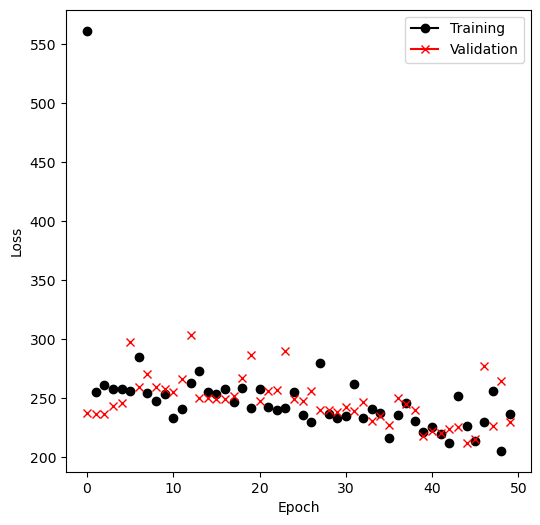

In [51]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
hit_results.plot(x='epoch', y='train_mae_epoch', label='Training',
                     marker='o', color='k', ax=ax)
hit_results.plot(x='epoch', y='valid_mae', label='Validation',
                        marker='x', color='r', ax=ax)
ax.set_xlabel('Epoch'); ax.set_ylabel('Loss');

In [31]:
#fig, ax = plt.subplots(1, 1, figsize=(6, 6))
#for column, color, label in zip(['train_mae_epoch', 'valid_mae'],
#                                ['black', 'red'],
#                                ['Training', 'Validation']):
#    hit_results.plot(x='epoch', y=column, label=label,
#                     marker='o', color=color, ax=ax)

- We predict from the final model and compute the MAE on the test data.
- We call `eval()` to set the model to evaluation mode. This tell `torch` that the model is fitted and we are ready to make predictions.
- The change is that the dropout layer is turned off during evaluation.

In [59]:
hit_model.eval()
preds = hit_model(X_test_t)
torch.abs(Y_test_t - preds).mean()

tensor(229.5011, grad_fn=<MeanBackward0>)

## Cleanup
We delete all references to the torch objects to terminate the worker processes from our data module.

In [33]:
del(Hitters,
    hit_model, hit_dm,
    hit_logger,
    hit_test, hit_train,
    X, Y,
    X_test, X_train,
    Y_test, Y_train,
    X_test_t, Y_test_t,
    hit_trainer, hit_module)